In [44]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt
import csv, datetime, random, sys
import matplotlib.dates as mdates
import pandas as pd

In [45]:
def MakeDataFromText(filepath):
    """
    Helper function to parse text files in IFM proprietary format.
    """
    with open(filepath, 'r') as file:
        reader = csv.reader(file)

        db = dict()                          # Dictionary that will hold k,v pairs of 
        recent_EPC = ''                      # The most recent EPC that was read, and data is being assigned to
        Time_Or_Data = True                  # Time is true, Data is false
        reached_24 = False

        for l in reader:                     # Iterate over entire text file
            line = l[0]                      # Each line only has one token, so we select it
            
            if len(line)==24:                # If it is an EPC
                db[line] = [[],[]]           # Create new k,v pair in database
                recent_EPC = line            # Current EPC to add to is selected
            
            elif line == '[':                # If start bracket, beginning to collect an array of data
                data = []

            elif line == ']':                # End bracket means end of data array
                if len(data)!=0:
                    if Time_Or_Data:
                        db[recent_EPC][0] = data
                        Time_Or_Data = False
                    else:
                        db[recent_EPC][1] = data
                        Time_Or_Data = True
                data = []

            elif len(line)==8:               # If it is a time stamp
                h,m,s = line.split(':')      # Parse timestamp into hours, minutes, seconds

                if int(h)==23:
                    reached_24 = True        # If end of day reached, must move to Day 2

                if reached_24 and int(h) < 12:
                    day=2
                else:
                    day=1

                data.append(datetime.datetime(1970, 2, day, int(h), int(m), int(s))) # Minus 3 for Pacific Time
            
            elif line ==' ':               # If blank space, then we skip to parse next line
                pass

            else:                          # If it is a data point
                try:
                    data.append(float(line))
                except:
                    pass                   # Error catching case just in case, so annoying errors don't crash program
    return db

In [46]:
t1 = MakeDataFromText("tags.txt")
t2 = MakeDataFromText("tags (1).txt")
t3 = MakeDataFromText("tags (2).txt")
t4 = MakeDataFromText("tags (3).txt")
t5 = MakeDataFromText("tags (4).txt")
t6 = MakeDataFromText("tags (5).txt")
t7 = MakeDataFromText("tags (6).txt")
t8 = MakeDataFromText("tags (7).txt")
t9 = MakeDataFromText("tags (8).txt")

# Combine all data into one dictionary
combined = dict()
for d in [ t1,t2,t3,t4,t5,t6,t7,t8,t9 ]:
    for k,v in d.items():
        if k in combined:                                 # if tag is already in dict
            for i in range(len(v[0])):                    # iterate over all time points
                if v[0][i] in combined[k]:                # if time point is already in dict
                    combined[k][v[0][i]].append(v[1][i])
                else:                                     # if time point is not in dict
                    combined[k][v[0][i]] = [v[1][i]]
        else:             # if tag is not in dict
            combined[k] = dict()
            for i in range(len(v[0])):
                combined[k][v[0][i]] = [v[1][i]]
for k,v in combined.items():
    for k2,v2 in v.items():
        combined[k][k2] = sum(v2)/len(v2) # avg all points taken during the same second

In [47]:
list_dfs = list()
epcs = [ '1FC1','96A1','5448','7561','5E01','30CE','67CC','7D24','9859','7D79','7263','34D7' ]


for k,v in combined.items():          # For each EPC in all the readings
    if k[-4:] in epcs:                # If we have the right EPC
        s = sorted( v.items() )
        time, data = [ j[0] for j in s ], [ j[1] for j in s ]

        sdf = pd.DataFrame(
            data = { 'Datetime':time, k[-4:]:data },
            columns=[ 'Datetime', k[-4:] ]
        )
        list_dfs.append(sdf)


# all_data = pd.concat([t for t in list_dfs], ignore_index=False)
# all_data = all_data.set_index('Datetime')
# all_data = all_data.sort_index()
# all_data = all_data.groupby(level=0).sum()
# all_data = all_data.groupby(all_data.index).sum()
# all_data = all_data.replace(0, "-")
# all_data.to_excel("test_data.xlsx")

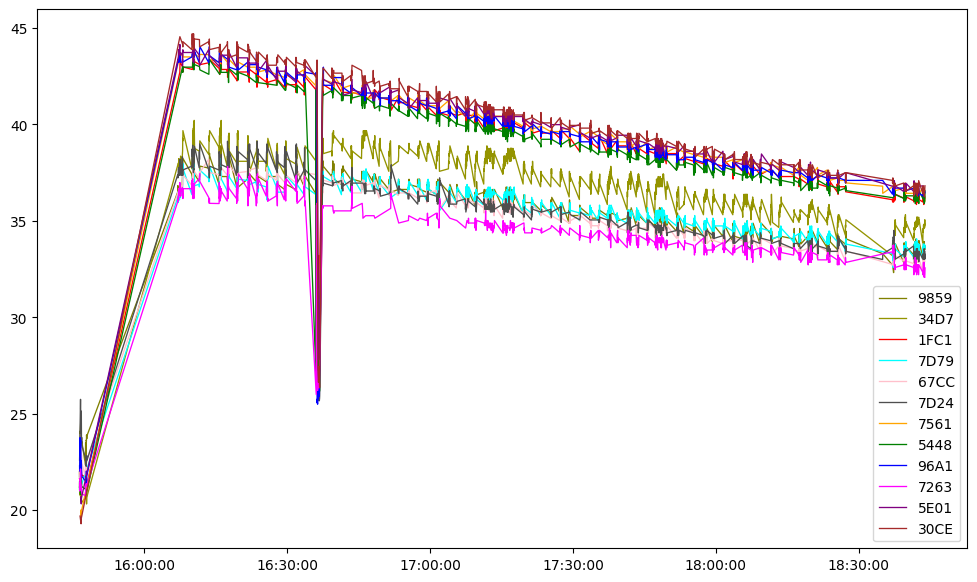

In [48]:
# PLOTTING CODE
fig, ax = plt.subplots(figsize=(12, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

color = {
    '1FC1':'red',
    '96A1':'blue',
    '5448':'green',
    '7561':'orange',
    '5E01':'purple',
    '30CE':'brown',
    '67CC':'pink',
    '7D24':'#4F4F4F',
    '9859':'olive',
    '7D79':'cyan',
    '7263':'magenta',
    '34D7':'#949400'
}

for k,v in combined.items():          # For each EPC in all the readings
    if k[-4:] in epcs:                # If we have the right EPC
        s = sorted( v.items() )
        time, data = [ j[0] for j in s ], [ j[1] for j in s ]

        ax.plot(time, data, label=k[-4:], color=color[k[-4:]], linewidth=0.95)

ax.legend()